Useful links

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/tutorials/images/classification

https://www.tensorflow.org/tutorials/images/data_augmentation

https://www.tensorflow.org/tutorials/images/transfer_learning

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_keras_vis.utils import num_of_gpus

[]

In [4]:
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


# Data preparation

## Loading the images

In [3]:
img_height = 224
img_width = 224

batch_size = 16

In [4]:
# load data from directories

train_ds = tf.keras.utils.image_dataset_from_directory(
  "train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "train/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test/",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 4080 files belonging to 5 classes.
Using 3264 files for training.
Found 4080 files belonging to 5 classes.
Using 816 files for validation.
Found 500 files belonging to 5 classes.


## Data exploration

In [5]:
class_names = train_ds.class_names
class_names

['0', '1', '2', '3', '4']

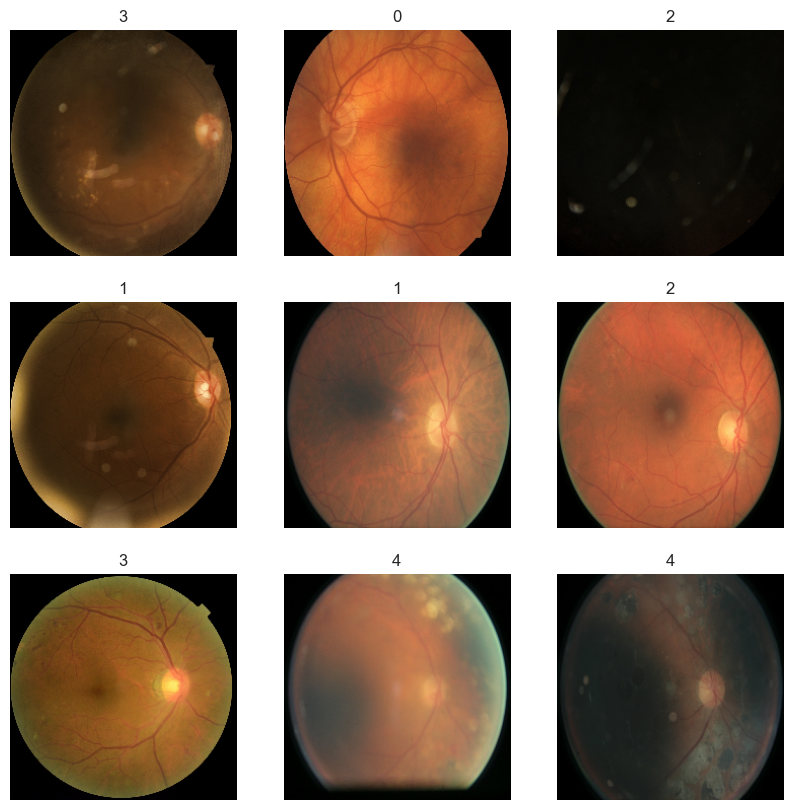

In [6]:
# visualize some images
plt.figure(figsize=(10, 10))
# take() takes a batch (according to batch_size)
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Some images are distorted due to irregular height/width. This might increase loss and decrease accuracy during training/testing.

In [7]:
input_shape = None
for image_batch, labels_batch in train_ds:
  input_shape = image_batch.shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


image: batch_size, image_height, image_width, RGB color channels

labels = batch_size,

## Data pre-processing
RGB color channels are in range [0,255], however we want to convert them to the range [0,1] as this is easier to handle for the CNN. We can achieve this with a Rescaling layer in the model.

# CNN

In [8]:
num_classes = len(list(train_ds.class_names))

In [9]:
epochs = 5

In [10]:
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.prefetch(buffer_size=batch_size)
#val_ds = val_ds.prefetch(buffer_size=batch_size)
# Unfortunately, caching and prefetching leads to high memory pressure and out of memory errors on our local machines.

## Model formulation (with reasoning)

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness([0.,0.8]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(batch_size, 3, activation='relu', input_shape=input_shape[1:]),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(batch_size, 3, activation='relu', input_shape=input_shape[1:]),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(batch_size, 3, activation='relu', input_shape=input_shape[1:]),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
204/204 [==============================] - 14s 63ms/step - loss: 1.6359 - accuracy: 0.2197 - val_loss: 1.6011 - val_accuracy: 0.2132
Epoch 2/5
204/204 [==============================] - 14s 69ms/step - loss: 1.6027 - accuracy: 0.2246 - val_loss: 1.6001 - val_accuracy: 0.2206
Epoch 3/5
204/204 [==============================] - 13s 63ms/step - loss: 1.6087 - accuracy: 0.2188 - val_loss: 1.5996 - val_accuracy: 0.2206
Epoch 4/5
204/204 [==============================] - 14s 66ms/step - loss: 1.6092 - accuracy: 0.2142 - val_loss: 1.6004 - val_accuracy: 0.2157
Epoch 5/5
204/204 [==============================] - 13s 65ms/step - loss: 1.6103 - accuracy: 0.2163 - val_loss: 1.6056 - val_accuracy: 0.2206


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0

In [15]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


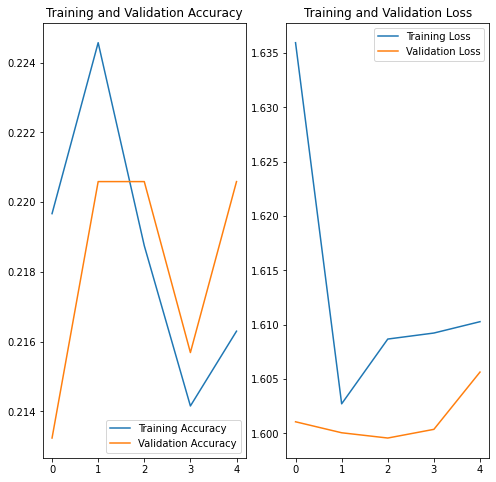

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
eval = model.evaluate(test_ds)
print("One the test set, the CNN achieves an accuracy of {} with a loss of {}.".format(eval[1],eval[0]))

32/32 [==============================] - 1s 20ms/step - loss: 1.6360 - accuracy: 0.2000
One the test set, the CNN achieves an accuracy of 0.20000000298023224 with a loss of 1.6360219717025757.


In [18]:
misclassified = []
misclassified_labels = []

for test_images, test_labels in test_ds.as_numpy_iterator():
    pred = model.predict(test_images)
    #print(pred.shape)
    #print(len(test_images))
    #print(len(test_labels))
    fake_batch_size = len(test_labels)
    for i in range(fake_batch_size-1):
        if test_labels[i] != np.argmax(pred[i]):
            misclassified.append(test_images[i])
            misclassified_labels.append((test_labels[i],np.argmax(pred[i])))
            #misclassified.append(test_images[i])
        #print(np.argmax(pred[j]))
            #if pred[i] != test_labels[i]:
            #    print("a")

1/1 [==============================] - 0s 36ms/step


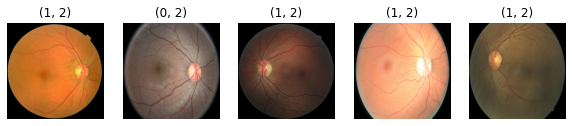

In [19]:
plt.figure(figsize=(10, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(misclassified[i].astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.title(misclassified_labels[i])
    plt.axis("off")
plt.show()

Conclusion: CNN struggles and seems to have no clue what it's doing

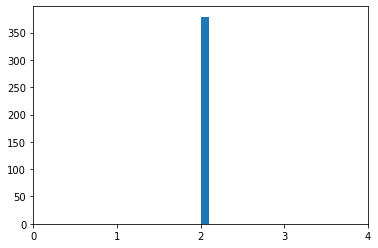

In [20]:
pred_labels = [x[1] for x in misclassified_labels]
plt.hist(pred_labels)
plt.xticks([0,1,2,3,4])
plt.show()

## Image augmentation

In [21]:
# zoom, rotation
# increase brightness?

In [22]:
# https://www.tensorflow.org/tutorials/images/data_augmentation 
# transfer learning?
# big transfer?
# vorgefertigte modelle resnet? (darauf achten welche auflösung die brauchen)


## Transfer Learning

https://www.tensorflow.org/tutorials/images/transfer_learning

In [20]:

base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3,),
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


In [10]:
base_model = tf.keras.applications.ResNet50(input_shape=(img_height,img_width,3,),
                                               include_top=False,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [22]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [24]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 5)


In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)
  #tf.keras.layers.RandomBrightness([0.,0.8])
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
len(model.trainable_variables)

2

In [27]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
204/204 [==============================] - 66s 277ms/step - loss: 1.6119 - accuracy: 0.3113 - val_loss: 1.4524 - val_accuracy: 0.3309
Epoch 2/10
 34/204 [====>.........................] - ETA: 35s - loss: 1.4733 - accuracy: 0.3566


KeyboardInterrupt



40% accuracy -> the model can accurately distinguish two classes

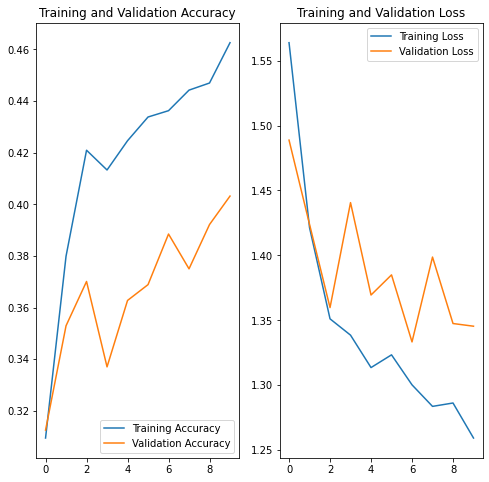

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
misclassified = []
misclassified_labels = []

for test_images, test_labels in test_ds.as_numpy_iterator():
    pred = model.predict(test_images)
    #print(pred.shape)
    #print(len(test_images))
    #print(len(test_labels))
    fake_batch_size = len(test_labels)
    for i in range(fake_batch_size-1):
        if test_labels[i] != np.argmax(pred[i]):
            misclassified.append(test_images[i])
            misclassified_labels.append((test_labels[i],np.argmax(pred[i])))
            #misclassified.append(test_images[i])
        #print(np.argmax(pred[j]))
            #if pred[i] != test_labels[i]:
            #    print("a")

1/1 [==============================] - 0s 430ms/step


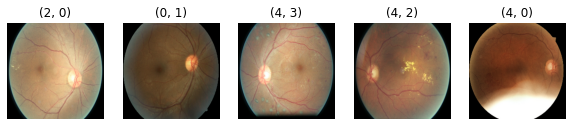

In [35]:
#left: true label, right: predicted label
plt.figure(figsize=(10, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(misclassified[i].astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.title(misclassified_labels[i])
    plt.axis("off")
plt.show()

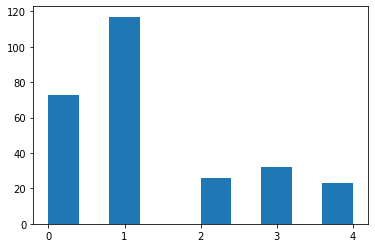

In [36]:
pred_labels = [x[1] for x in misclassified_labels]
plt.hist(pred_labels)
plt.xticks([0,1,2,3,4])
plt.show()

In [37]:
#TODO: fine-tine https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning

In [38]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [45]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [46]:
len(model.trainable_variables)

56

In [47]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
114/204 [===============>..............] - ETA: 16s - loss: 2.9989 - accuracy: 0.1985

KeyboardInterrupt: 

## Training
- plot loss and accuracy
- save trained model

# Transformer

## Deciding on a model
- from scratch?
- pre-defined? huggingface,...

## Training
- plot loss and accuracy
- save trained model

# Evaluation
Compare the performances of the CNN and Transformer model.
- test set evaluation
- confusion matrix
- average inference time
- show five misclassified examples each and discuss possible reasons

In [43]:
model.evaluate(test_ds)

32/32 [==============================] - 2s 48ms/step - loss: 1.3455 - accuracy: 0.4140


[1.3454954624176025, 0.414000004529953]

## Attention map
https://medium.com/cermati-tech/attention-maps-for-visualizing-the-recaptured-image-classification-models-30822bb209f
- for five misclassified examples each
- discuss appropriateness of these attention maps (is the model focusing on the right thing?)